# Volatility Model : from implied volatility to local volality using Dupire's equation

This notebook shows how to display the implied volatility surface and computes the local volatiltiy surface, using AssetPricing functions.
The implied volatility is a volatility model stating that unlike the assumptions of Black,Scholes and Merton, the underlying volatility of an asset isn't constant. It rather states that the volatility vary over time and over the spot price. This mean sigma is a function of S and T, often wrote $\sigma$(S,T). 

$$
local vol = \frac{\sum^2 + 2T\sum\left(\frac{\partial \sum}{\partial T} + (r_T - r_Q)K \frac{\partial^2 \sum}{\partial K^2}\right)}{\left(1 + \frac{K_y}{\sum} \frac{\partial \sum}{\partial K}\right)^2 + K\sum T \left[\frac{\partial \sum}{\partial K} - \frac{1}{4}\sum KT \left(\frac{\partial \sum}{\partial K}\right)^2 + K \frac{\partial^2 \sum}{\partial K^2}\right]}
$$


In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from numpy import meshgrid
import yfinance as yf
import datetime as dt

First, we define our function to download option data

In [5]:
def get_option_data(ticker):
    asset = yf.Ticker(ticker)
    expirations = asset.options

    chains = pd.DataFrame()
    # iterate over expiry dates
    for expiration in expirations:
        # tuple of two dataframes
        opt = asset.option_chain(expiration)

        calls = opt.calls
        calls['optionType'] = "call"
        puts = opt.puts
        puts['optionType'] = "put"

        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)

        chains = pd.concat([chains, chain])

    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    chains["Expiry"] = chains["daysToExpiration"] / 365

    return chains

In [6]:
ticker = "AAPL"
chains = get_option_data(ticker)
chains

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expiration,daysToExpiration,Expiry
0,AAPL230915C00065000,2023-09-11 17:32:16+00:00,65.0,114.35,114.15,115.05,1.250000,1.105217,4.0,111,4.410161,True,REGULAR,USD,call,2023-09-15 23:59:59,4,0.010959
1,AAPL230915C00070000,2023-09-11 17:32:16+00:00,70.0,109.35,109.15,110.05,-3.860001,-3.409593,4.0,6100,4.109380,True,REGULAR,USD,call,2023-09-15 23:59:59,4,0.010959
2,AAPL230915C00075000,2023-09-11 15:41:40+00:00,75.0,103.60,103.65,105.25,-4.720001,-4.357461,1.0,1608,3.375002,True,REGULAR,USD,call,2023-09-15 23:59:59,4,0.010959
3,AAPL230915C00080000,2023-09-11 19:58:22+00:00,80.0,99.48,99.15,99.80,-10.070000,-9.192149,1.0,693,3.234377,True,REGULAR,USD,call,2023-09-15 23:59:59,4,0.010959
4,AAPL230915C00085000,2023-09-07 14:39:44+00:00,85.0,91.65,94.20,95.15,0.000000,0.000000,2.0,711,3.457033,True,REGULAR,USD,call,2023-09-15 23:59:59,4,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,AAPL251219P00270000,2023-09-06 14:21:06+00:00,270.0,85.15,89.20,92.35,0.000000,0.000000,1.0,0,0.181344,True,REGULAR,USD,put,2025-12-19 23:59:59,830,2.273973
43,AAPL251219P00280000,2023-08-21 13:33:35+00:00,280.0,105.25,98.60,102.30,0.000000,0.000000,5.0,0,0.191842,True,REGULAR,USD,put,2025-12-19 23:59:59,830,2.273973
44,AAPL251219P00290000,2023-06-28 14:34:27+00:00,290.0,101.00,91.85,94.95,0.000000,0.000000,1.0,0,0.000010,True,REGULAR,USD,put,2025-12-19 23:59:59,830,2.273973
45,AAPL251219P00300000,2023-08-09 15:06:30+00:00,300.0,122.00,118.20,121.85,0.000000,0.000000,2.0,0,0.200753,True,REGULAR,USD,put,2025-12-19 23:59:59,830,2.273973


We now need to clean our dataset

In [22]:
def clean_option_data(df: pd.DataFrame):
    """
    This function is a must called before calibrating a vol surface. It cleans dataset by removing irrelevant data
    based on the following conditions :
    - trade must have occurred within last X business days
    - spread must be smaller than expiry spread min + 4 * expiry spread std.
    - volume / open interest has to be valid
    """

    # # Filter out options with high bid/ask spreads
    df['spread'] = df['ask'] - df['bid']
    spread_mean = df.groupby('Expiry')['spread'].mean()
    spread_std = df.groupby('Expiry')['spread'].std()
    merged = pd.concat([spread_mean, spread_std], axis=1).reset_index()
    merged.columns = ['Expiry', 'mean', 'std']
    df = df.merge(merged, on='Expiry')
    df = df[df['spread'] < (df['mean'] + 4 * df['std'])]

    # Filter out options that haven't been traded in the last 5 business days
    df['lastTradeDate'] = pd.to_datetime(df['lastTradeDate'])
    five_days_ago = pd.Timestamp.now().normalize() - pd.offsets.BDay(5)
    five_days_ago = five_days_ago.tz_localize('UTC')
    # df = df[df['lastTradeDate'] > five_days_ago]
    # Disabling filtering because lack of data

    df = df.drop(columns=['spread', 'mean', 'std'])

    # Filter out options with zero or NaN volume
    df = df[(df['volume'].notna()) & (df['volume'] != 0)]

    # Filter out options with zero or NaN open interest
    df = df[(df['openInterest'].notna()) & (df['openInterest'] != 0)]
    
    # Filter out options that are in the money
    df = df[df['inTheMoney'] == False]
    
    # return only interesting cols
    df = df[['lastPrice', 'strike', 'Expiry', 'optionType',
        'impliedVolatility', 'Dividend', 'Spot', 'Risk-Free Rate']]
    
    
    return df

We define our parameters before starting

In [8]:
r = 0.0542  # 1 year risk-free risk in %
q = 0.0054  # apple annual dividend rate in %
chains['Dividend'] = q
chains['Spot'] = yf.download(ticker, period="1d")['Close'][-1]
chains['Risk-Free Rate'] = r

[*********************100%%**********************]  1 of 1 completed


In [24]:
cleaned_data = clean_option_data(chains)
cleaned_data

,lastPrice,strike,Expiry,optionType,impliedVolatility,Dividend,Spot,Risk-Free Rate
29,2.02,180.0,0.010959,call,0.310065,0.0054,179.360001,0.0542
30,1.06,182.5,0.010959,call,0.305427,0.0054,179.360001,0.0542
31,0.51,185.0,0.010959,call,0.306403,0.0054,179.360001,0.0542
32,0.25,187.5,0.010959,call,0.315437,0.0054,179.360001,0.0542
33,0.13,190.0,0.010959,call,0.332038,0.0054,179.360001,0.0542
...,...,...,...,...,...,...,...,...
1611,13.30,155.0,2.273973,put,0.227699,0.0054,179.360001,0.0542
1612,14.04,160.0,2.273973,put,0.227821,0.0054,179.360001,0.0542
1613,15.40,165.0,2.273973,put,0.222084,0.0054,179.360001,0.0542
1614,17.40,170.0,2.273973,put,0.215981,0.0054,179.360001,0.0542


# Implied Volatility Surface

Now that we have cleaned data, let's build and plot the implied volatility surface

In [10]:
from vol_utils import implied_volatility_row
# This imports implied volatility extraction function using newton bisection, black and scholes pricer and vega calculator.

In [11]:
def get_skew(T, df):
    """
    Extract Implied volatility from options prices for a given maturity T
    """
    # filter the input DataFrame to only contain data for the given `Expiry`
    df_filtered = df[df['Expiry'] == T]

    # filter the DF. We only use put data for now, for which implied vol is sufficient
    puts = df_filtered[(df_filtered['impliedVolatility'] > 0.0001)].copy()

    puts['impliedVol'] = puts.apply(implied_volatility_row, axis=1)
    puts.set_index('strike', inplace=True)
    return puts['impliedVol']

def implied_vol_surface(df):
    """
    Builds dataframe with implied volatility extracted from options prices
    """

    # filter the DataFrame to only contain 'Expiry' between 0.5 and 2.5
    expiry_filtered = df[(df['Expiry'] >= 0.5) & (df['Expiry'] <= 2.5)]

    # group the filtered DataFrame by 'Expiry' and apply the `get_Skew` function to each group
    expiries = expiry_filtered['Expiry'].unique()
    vol_matrix = {}
    for T in expiries:
        skew_df = get_skew(T, expiry_filtered)
        vol_matrix[T] = skew_df

    vol_matrix = pd.DataFrame(vol_matrix)

    return vol_matrix

This will actually build a dataframe with the strikes as index, the expiry as columns and the implied vol as values

In [12]:
def plot_implied_volatility_surface(df):
    expiry_values = df.columns
    strike_values = df.index
    Y, X = meshgrid(expiry_values, strike_values)
    Z = df.values

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Use the 'hot' colormap to represent higher Z values as redder
    surf = ax.plot_surface(X, Y, Z, cmap="coolwarm")

    # Add a color bar to the plot
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.2)

    ax.set_xlabel('Strike')
    ax.set_ylabel('Expiry')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Implied Volatility Surface')

    plt.show()

In [25]:
cleaned_data = cleaned_data[cleaned_data["optionType"] == "put"]
cleaned_data

,lastPrice,strike,Expiry,optionType,impliedVolatility,Dividend,Spot,Risk-Free Rate
62,0.01,65.0,0.010959,put,3.000002,0.0054,179.360001,0.0542
63,0.01,70.0,0.010959,put,2.750003,0.0054,179.360001,0.0542
64,0.01,75.0,0.010959,put,2.562504,0.0054,179.360001,0.0542
65,0.01,80.0,0.010959,put,2.375004,0.0054,179.360001,0.0542
66,0.01,85.0,0.010959,put,2.250004,0.0054,179.360001,0.0542
...,...,...,...,...,...,...,...,...
1611,13.30,155.0,2.273973,put,0.227699,0.0054,179.360001,0.0542
1612,14.04,160.0,2.273973,put,0.227821,0.0054,179.360001,0.0542
1613,15.40,165.0,2.273973,put,0.222084,0.0054,179.360001,0.0542
1614,17.40,170.0,2.273973,put,0.215981,0.0054,179.360001,0.0542


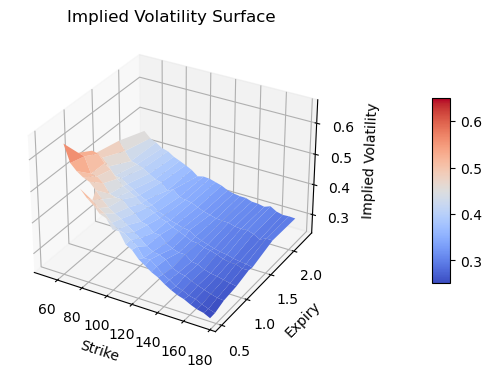

In [26]:
matrix = implied_vol_surface(cleaned_data)

plot_implied_volatility_surface(matrix)

# Calibration of local volatility

The concept of local volatilty states that there is function $\sigma$(S,T) that links the all the points of the previously plotted volatility surface. We will use a Parametric function to calibrate this function $\sum$ . Dumas et Al proposed the following : 
$\sum (\beta , T, K) = \beta_0 + \beta_1 K + \beta_2 T + \beta_3 K^2 + \beta_4 T^2 + \beta_5 TK$ . We will now use an ols regression to find our coefficients

In [27]:
def fit_model(vol_surface):
    # Create lists to store the data for all combinations of strikes and expiries
    strike_values = []
    expiry_values = []
    implied_volatility_values = []

    # Iterate through all combinations of expiry and strike and collect the data
    for expiry in vol_surface.columns:
        for strike in vol_surface.index:
            strike_values.append(strike)
            expiry_values.append(expiry)
            implied_volatility_values.append(vol_surface.loc[strike, expiry])

    # Create a DataFrame to store the data
    data = pd.DataFrame({
        'Strike': strike_values,
        'Expiry': expiry_values,
        'ImpliedVolatility': implied_volatility_values,
        'K': [strike ** 1 for strike in strike_values],
        'T': [expiry for expiry in expiry_values],
        'K^2': [strike ** 2 for strike in strike_values],
        'T^2': [expiry ** 2 for expiry in expiry_values],
        'T*K': [expiry * strike for strike, expiry in zip(strike_values, expiry_values)],
        'Constant': 1  # Add a constant term
    })

    # remove all np.nan in implied vol
    data = data.dropna()
    # Fit the OLS regression model
    model = sm.OLS(data['ImpliedVolatility'], data[['K', 'T', 'K^2', 'T^2', 'T*K', 'Constant']]).fit()

    return model

In [29]:
local_vol_mod = fit_model(matrix)
print(local_vol_mod.summary())

                            OLS Regression Results                            
Dep. Variable:      ImpliedVolatility   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2814.
Date:                Tue, 12 Sep 2023   Prob (F-statistic):          2.37e-180
Time:                        03:12:31   Log-Likelihood:                 645.60
No. Observations:                 202   AIC:                            -1279.
Df Residuals:                     196   BIC:                            -1259.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
K             -0.0064      0.000    -46.133      0.0

As we have found $\sum (K,T)$ , we can now use the following formula to get the local volatility :
$$
local vol = \frac{\sum^2 + 2T\sum\left(\frac{\partial \sum}{\partial T} + (r_T - r_Q)K \frac{\partial^2 \sum}{\partial K^2}\right)}{\left(1 + \frac{K_y}{\sum} \frac{\partial \sum}{\partial K}\right)^2 + K\sum T \left[\frac{\partial \sum}{\partial K} - \frac{1}{4}\sum KT \left(\frac{\partial \sum}{\partial K}\right)^2 + K \frac{\partial^2 \sum}{\partial K^2}\right]}
$$


Hence our choice of parametrization, the partial derivatives can be easily computed : 

$\frac {\partial \sum} {\partial T} = \beta_2 + 2\beta_4T + \beta_5K $

$\frac {\partial \sum} {\partial K}= \beta_1 + 2\beta_3K + \beta_5T $

$\frac {\partial^2 \sum} {\partial K^2} = 2\beta_3$


First let's define a function that uses our $\sum (K,T)$ function to get implied volatility, then we will compute local volatility

In [1]:
def compute_local_vol(model, K, T):

    # Calculate K², T², and T*K
    desired_K2 = K ** 2
    desired_T2 = T ** 2
    desired_TK = K * T

    # Create a DataFrame with the desired values of K, T, K², T², and T*K
    input_data = pd.DataFrame({
        'K': [K],
        'T': [T],
        'K^2': [desired_K2],
        'T^2': [desired_T2],
        'T*K': [desired_TK],
        'Constant': [1]
    })

    # Use the trained model to predict implied volatility
    implied_variance = model.predict(input_data[['K', 'T', 'K^2', 'T^2', 'T*K', 'Constant']])

    return implied_variance